In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import re
import string
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from wordcloud import WordCloud,STOPWORDS
import itertools
from sklearn.metrics import classification_report
import scipy as sp
from scipy.interpolate import make_interp_spline, BSpline
import ipywidgets as widgets

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
#import dataset
df_love = pd.read_csv(r'C:\Users\Shin\Documents\UM\UM\Year 2 Sem 2\WID3006 Machine Learning\Assignment\final_loveletter.csv')

#separate love letter and non-love letter into two dataframe
df_nonlove = df_love.loc[df_love['labels'] == 0]
df_onlylove = df_love.loc[df_love['labels'] == 1]

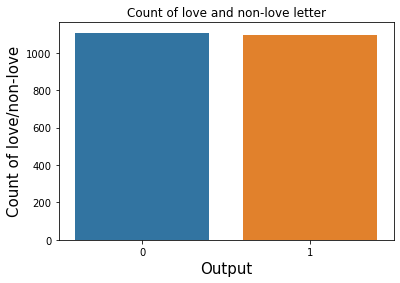

In [7]:
#showing amount of data after undersampling 
ax=sns.countplot(x="labels", data=df_love)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of love/non-love',title='Count of love and non-love letter')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

In [8]:
clean_letter=df_love.copy()

In [9]:
#Make text lowercase, remove text in square brackets,remove punctuation and remove words containing numbers.
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [10]:
stop = stopwords.words('english')
stop.append('doe')

In [11]:
#removing stop words
clean_letter['text'] = clean_letter['text'].apply(lambda x:review_cleaning(x))
clean_letter['text'] = clean_letter['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [12]:
#data cleaning for only love letter data
clean_onlylove = df_onlylove.copy()
clean_onlylove['text'] = clean_onlylove['text'].apply(lambda x:review_cleaning(x))
clean_onlylove['text'] = clean_onlylove['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [13]:
#data cleaning for non-love letter data
clean_nonlove = df_nonlove.copy()
clean_nonlove['text'] = clean_nonlove['text'].apply(lambda x:review_cleaning(x))
clean_nonlove['text'] = clean_nonlove['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

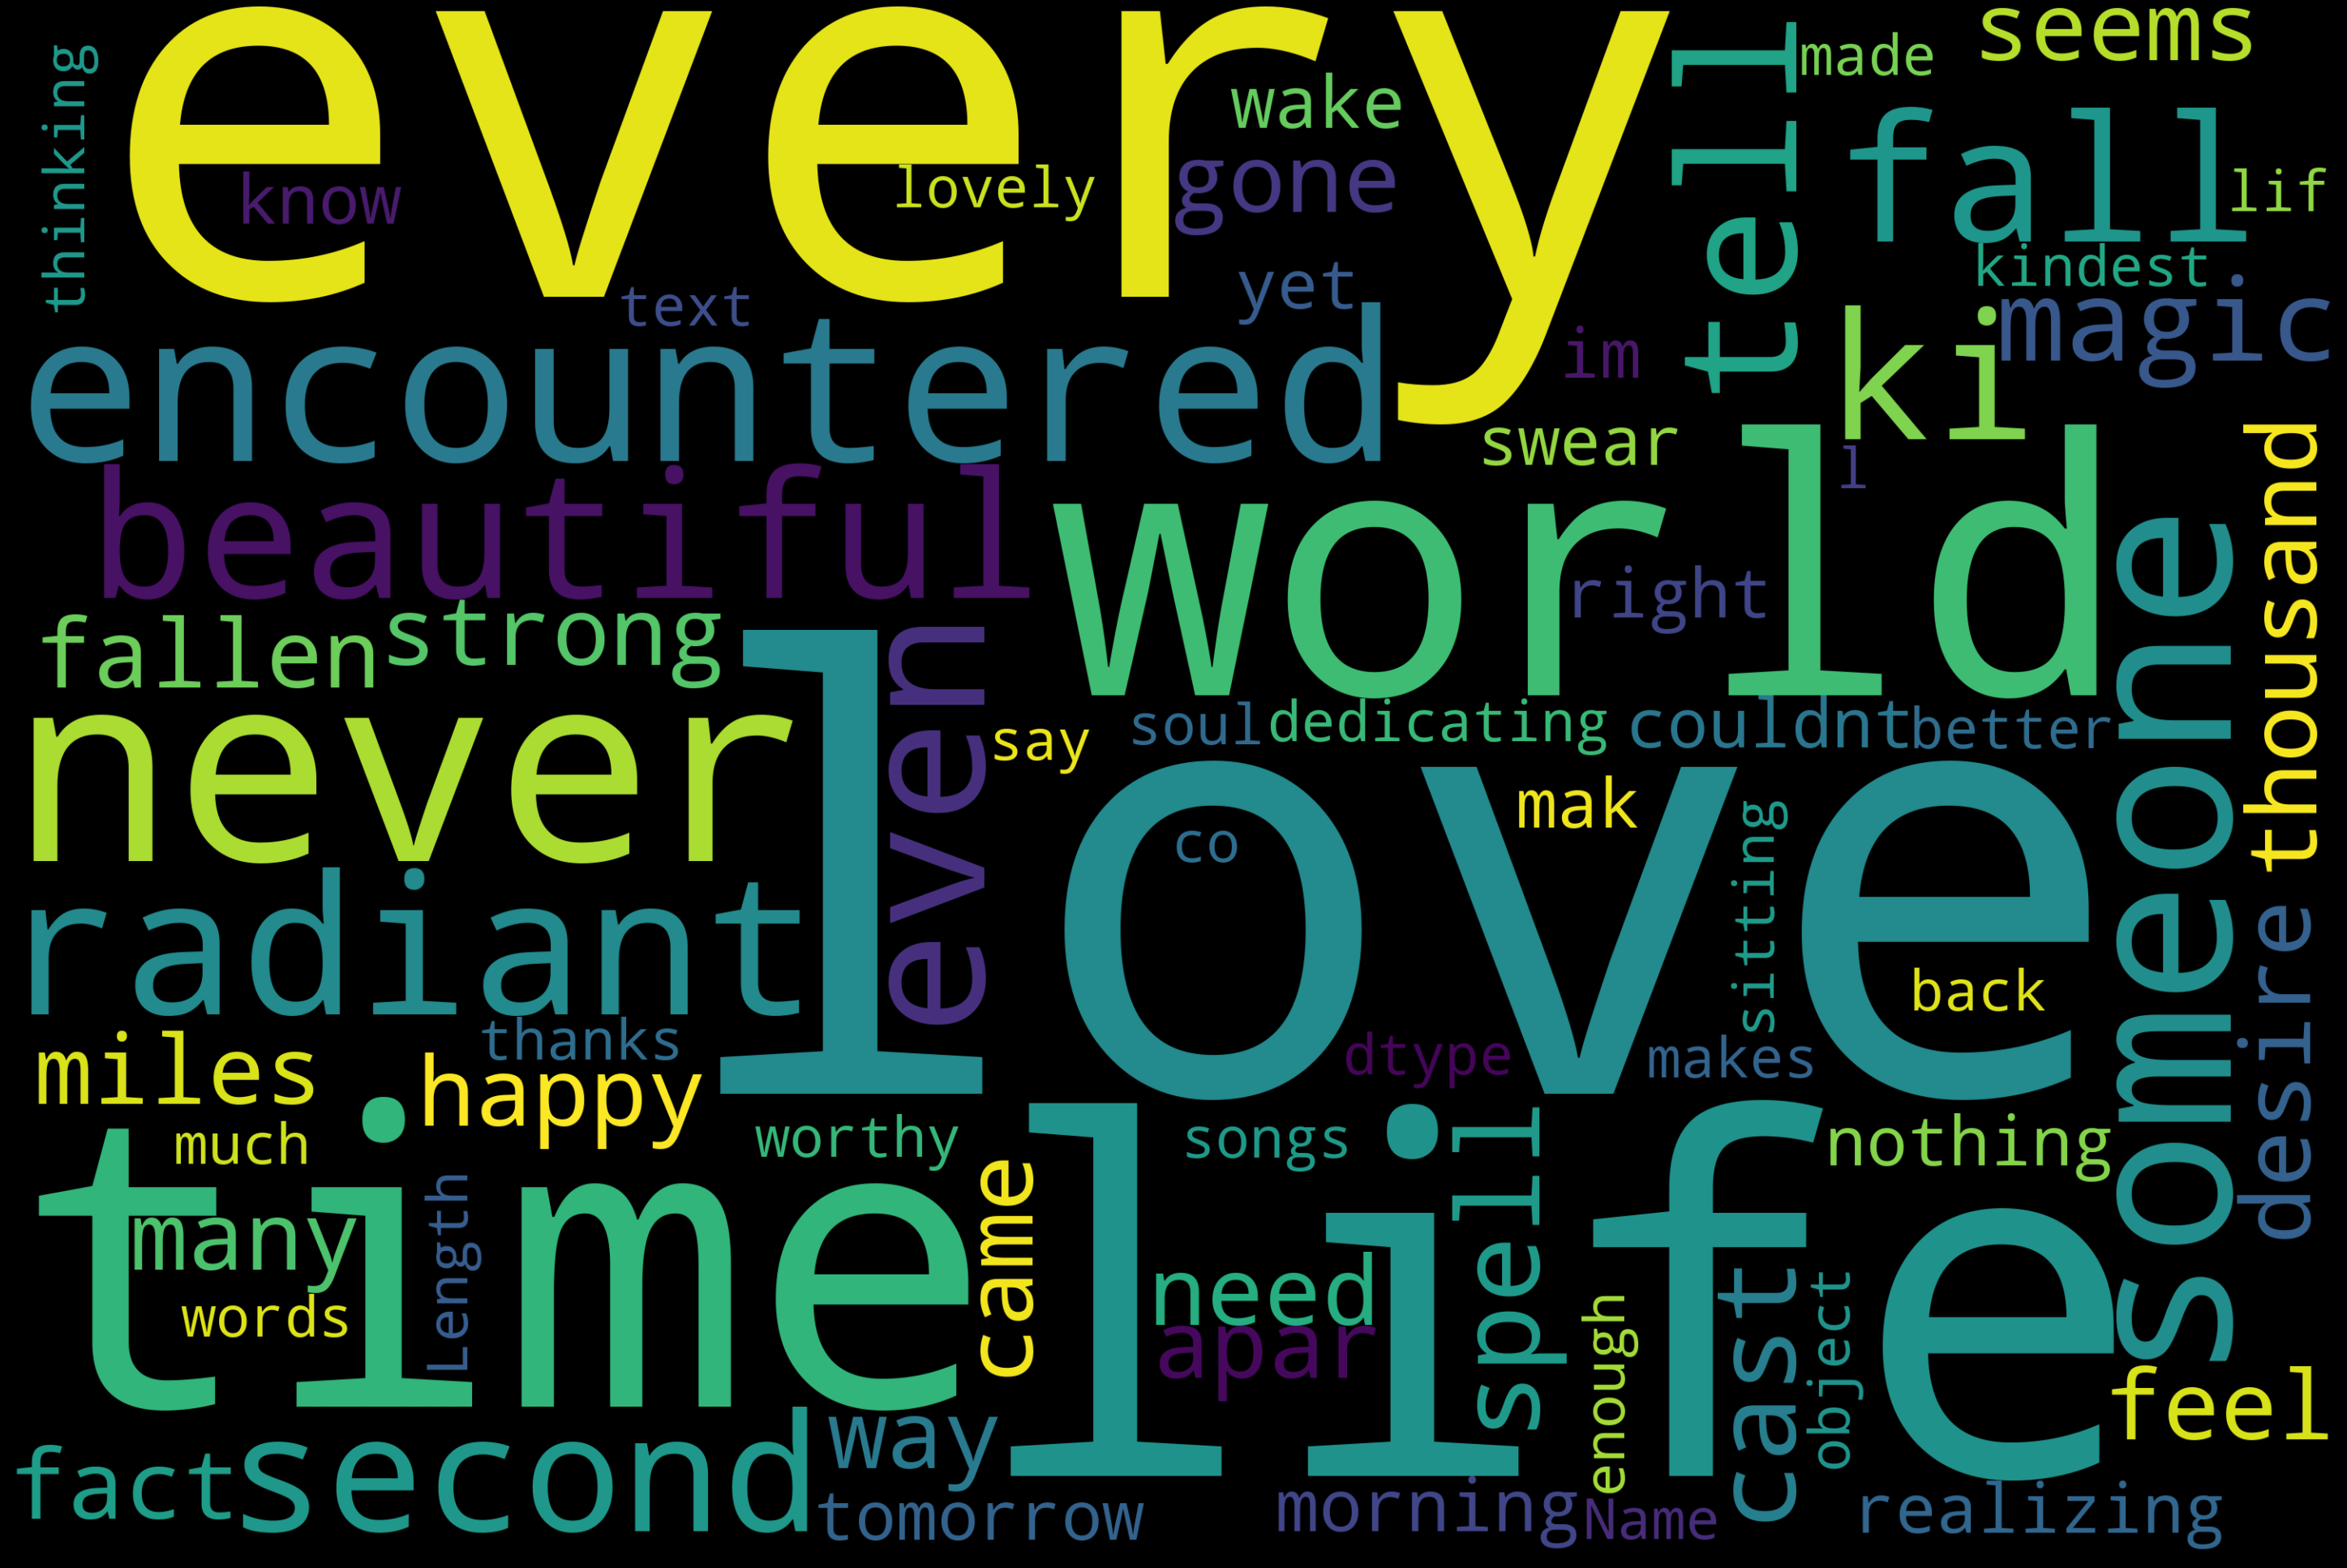

In [14]:
#initialize word cloud of love letter
text = clean_onlylove["text"]
wordcloud = WordCloud(width = 3000,height = 2000, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

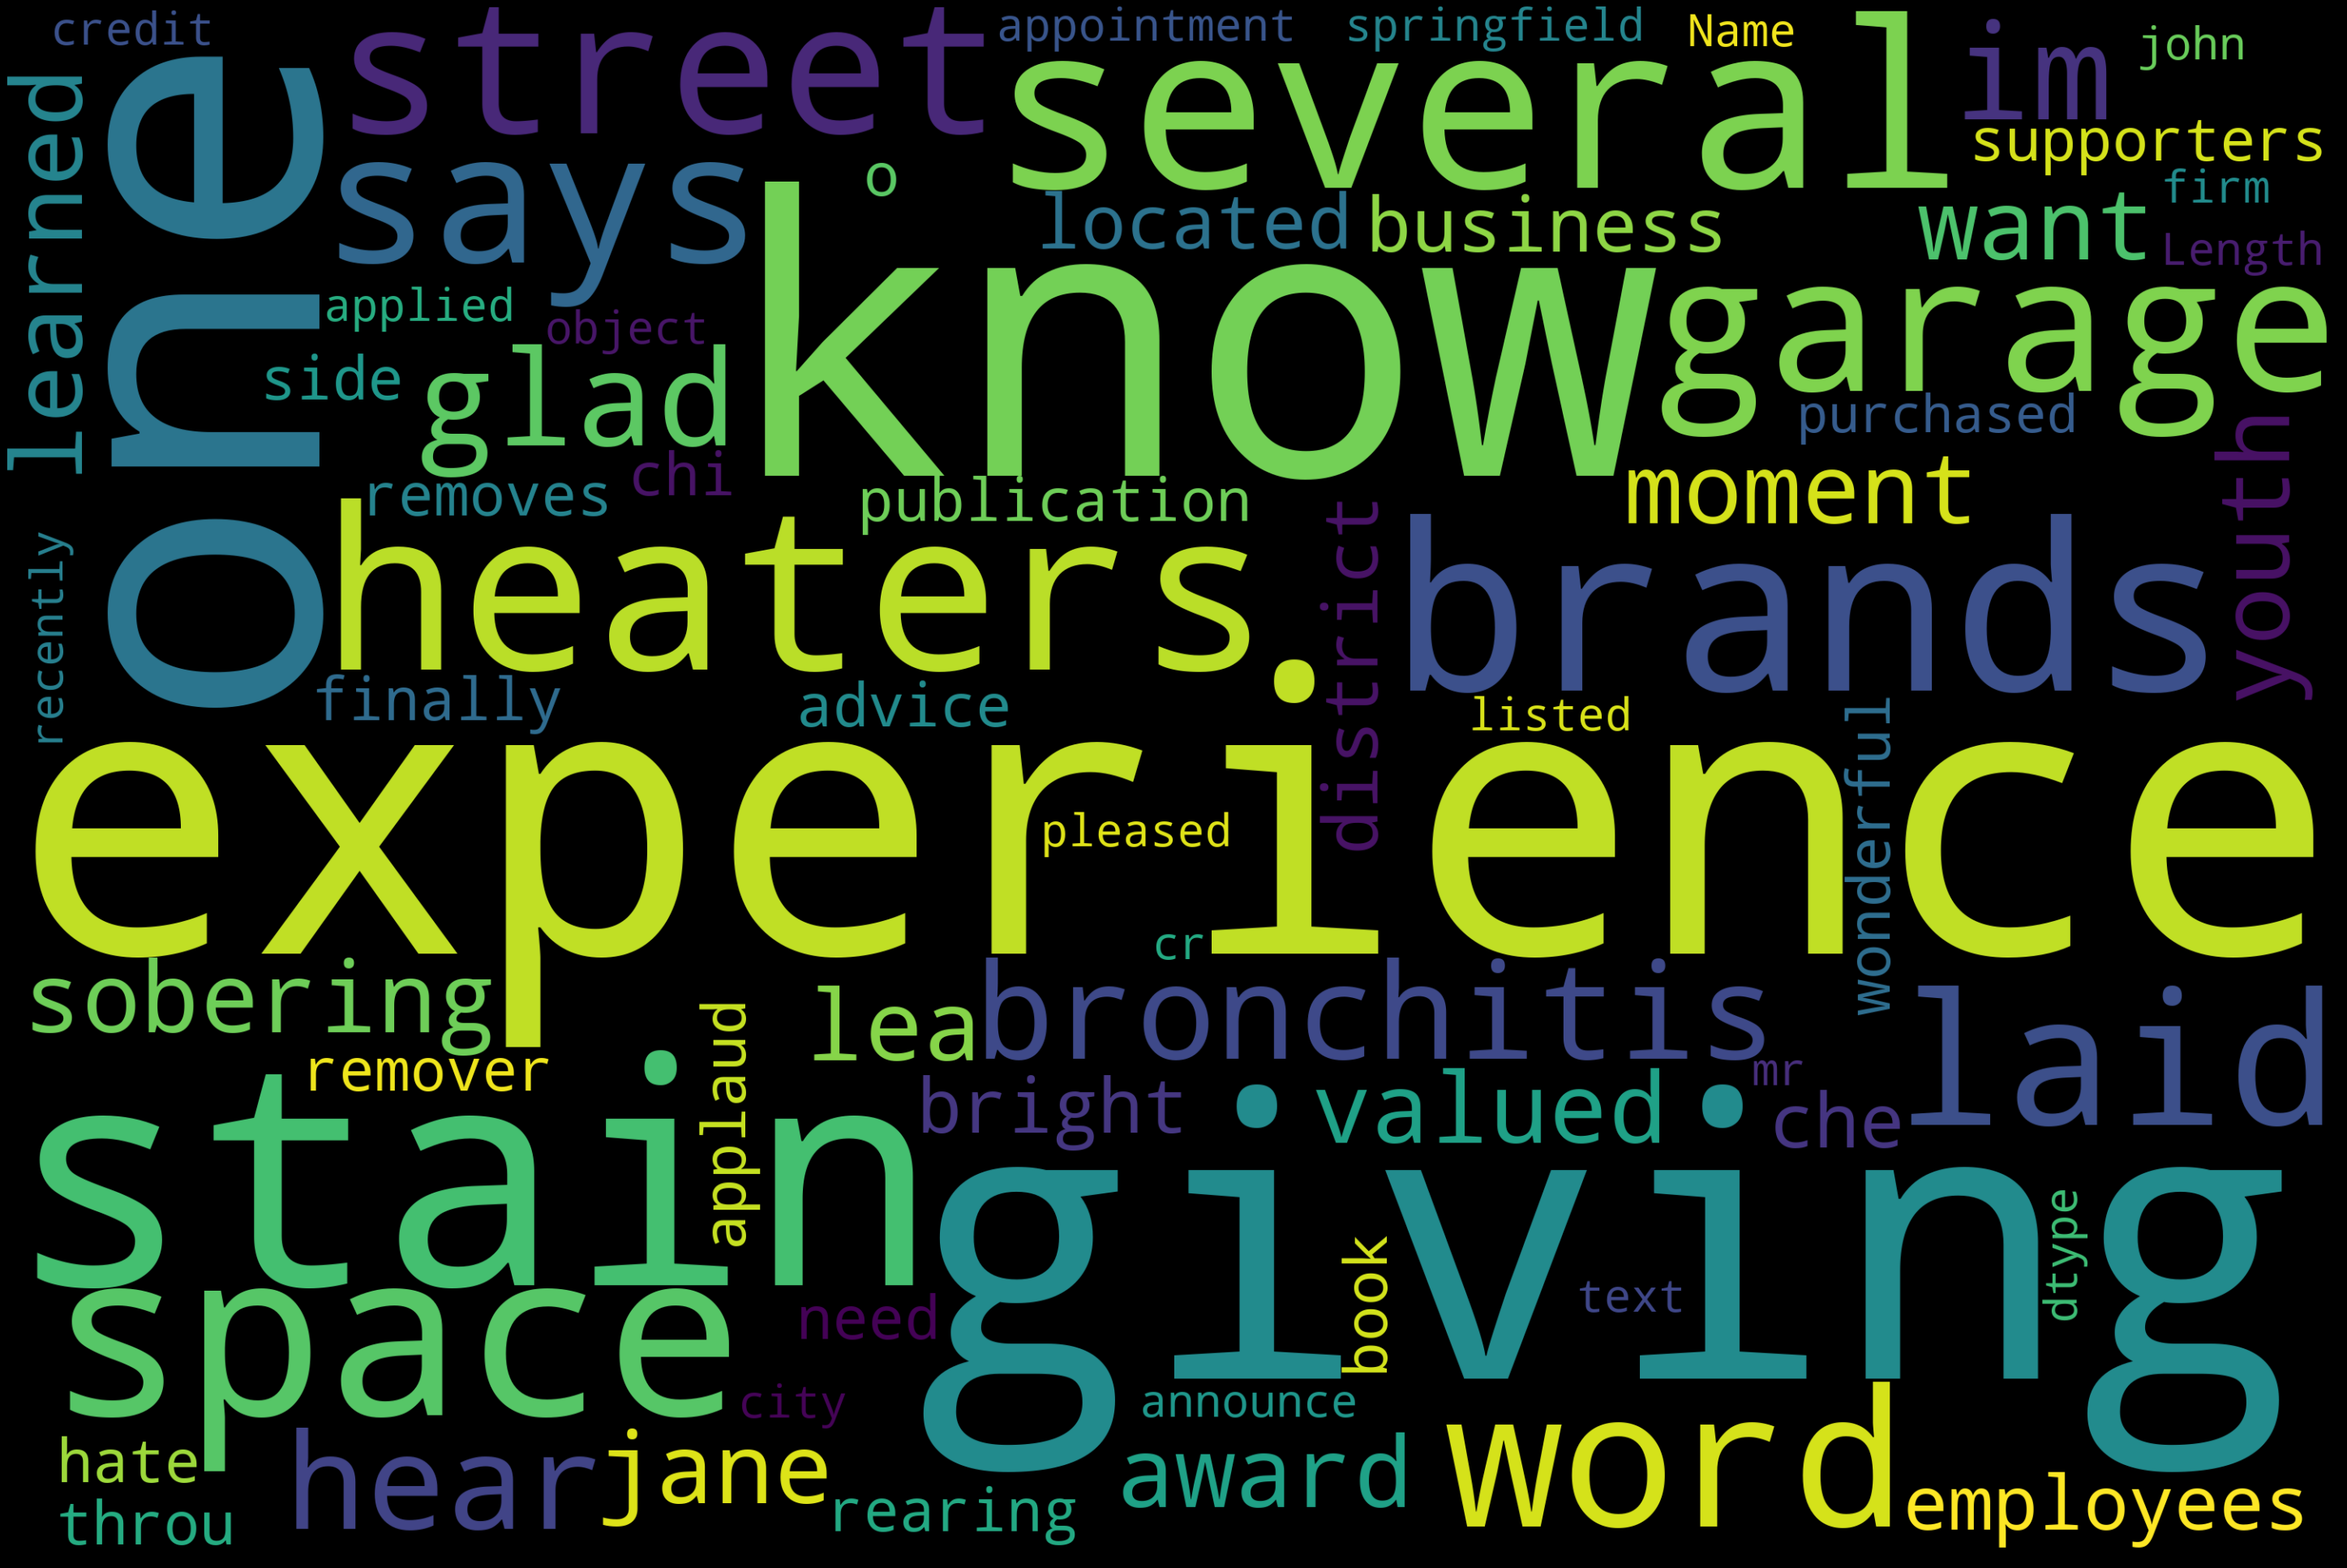

In [15]:
#initialize word cloud of non-love letter
text = clean_nonlove["text"]
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

C:\Users\Shin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



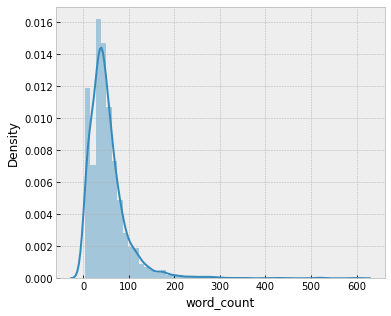

In [16]:
#Extracting the features from the letter
clean_letter['polarity'] = clean_letter['text'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_letter['review_len'] = clean_letter['text'].astype(str).apply(len)
clean_letter['word_count'] = clean_letter['text'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('bmh')

# plt.subplot(131)
# sns.distplot(clean_letter['polarity'])
# fig = plt.gcf()

# plt.subplot(132)
# sns.distplot(clean_letter['review_len'])
# fig = plt.gcf()

plt.subplot(133)
sns.distplot(clean_letter['word_count'])
fig = plt.gcf()

In [17]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_letter['text'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df = pd.DataFrame(common_words, columns = ['text' , 'frequency'])

#Group by words and plot the sum
df.groupby('text').sum()['frequency'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='frequency', linecolor='black', title='Top 20 words in letters')

love 2802
know 1421
would 930
want 899
life 895
time 841
heart 772
one 763
us 748
feel 735
much 708
always 677
never 662
like 656
day 650
please 609
could 576
make 537
thank 528
every 524


In [18]:
onlylove_words = get_top_n_words(clean_onlylove['text'])
df_onlylove_words = pd.DataFrame(onlylove_words,columns=('text','frequency'))
df_onlylove_words

list_onlylove = df_onlylove_words[:20]
df = pd.DataFrame(list_onlylove, columns=('text','frequency'))
df.groupby('text').sum()['frequency'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='frequency', linecolor='black', title='Top 20 words in love letters')

print(list_onlylove)

        text  frequency
0       love       2788
1       know       1133
2       life        862
3       want        764
4      heart        757
5      never        630
6       feel        627
7        day        592
8       much        585
9        one        583
10    always        580
11      time        519
12     would        515
13     could        485
14      like        476
15     every        469
16      ever        418
17  together        412
18      dont        403
19        us        389


In [19]:
nonlove_words = get_top_n_words(clean_nonlove['text'])
df_nonlove_words = pd.DataFrame(nonlove_words,columns=('text','frequency'))

list_nonlove = df_nonlove_words[:20]
df = pd.DataFrame(list_nonlove, columns=('text','frequency'))
df.groupby('text').sum()['frequency'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='frequency', linecolor='black', title='Top 20 words in non-love letters')

print(list_nonlove)

           text  frequency
0        please        479
1         would        415
2            us        359
3         thank        333
4          time        322
5           new        314
6          know        288
7          work        271
8   springfield        271
9         years        259
10         help        247
11         john        205
12         hope        204
13          may        203
14         jane        193
15         call        191
16   appreciate        190
17     enclosed        185
18          one        180
19         like        180


In [20]:
total = 0
for word,freq in onlylove_words:
    total += freq
print("Total number of words in love letter:",total)

text = "you mean so much to me."
text = review_cleaning(text)
text = text.split(" ")
list_love = []
for word, freq in onlylove_words:
    for i in text:
        if word == i:
            list_temp = []
            list_temp.append(word)
            list_temp.append(freq)
            list_love.append(list_temp)
print(list_love)

Total number of words in love letter: 64423
[['much', 585], ['mean', 141], ['you', 22], ['me', 13], ['to', 2]]


In [21]:
total = 0
for word,freq in nonlove_words:
    total += freq
print("Total number of words in non-love letter:",total)

list_love = []
for word, freq in nonlove_words:
    for i in text:
        if word == i:
            list_temp = []
            list_temp.append(word)
            list_temp.append(freq)
            list_love.append(list_temp)
print(list_love)

Total number of words in non-love letter: 52453
[['much', 123], ['mean', 5]]


In [22]:
y = clean_letter.labels

In [23]:
#splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(clean_letter['text'],y,test_size=0.33,random_state=53)

#initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words="english")

#transform string data into corpus
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)
print("Words in vocabulary: ",len(count_vectorizer.vocabulary_))
print(count_vectorizer.vocabulary_)

Words in vocabulary:  9567
{'government': 3658, 'eased': 2638, 'import': 4187, 'tariffs': 8329, 'wool': 9383, 'products': 6466, 'negotiated': 5560, 'new': 5579, 'agreement': 244, 'australian': 616, 'supplier': 8205, 'pleased': 6207, 'pass': 5989, 'savings': 7325, 'anticipate': 392, 'prices': 6408, 'winter': 9334, 'clothing': 1487, 'reduced': 6811, 'receive': 6760, 'price': 6404, 'catalog': 1245, 'near': 5530, 'future': 3518, 'meantime': 5179, 'rest': 7080, 'assured': 571, 'effect': 2667, 'orders': 5827, 'postmarked': 6309, 'september': 7469, 'pleasure': 6214, 'meet': 5197, 'needs': 5547, 'quality': 6615, 'wear': 9209, 'lowest': 5012, 'possible': 6295, 'love': 4981, 'best': 840, 'friend': 3447, 'confidante': 1697, 'unitedunited': 8898, 'unlike': 8910, 'experienced': 3013, 'grateful': 3694, 'blessedyou': 910, 'amaze': 312, 'make': 5072, 'dance': 2044, 'walk': 9137, 'sing': 7662, 'talked': 8314, 'horizon': 4049, 'room': 7212, 'teach': 8346, 'bewhen': 853, 'fell': 3187, 'taught': 8338, 'bl

In [84]:
alphas = np.linspace(0,1,1000)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(count_train,y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(count_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test,pred)
    return score


C:\Users\Shin\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



Highest accuracy: 0.989010989010989 
Alpha: 0.009009009009009009


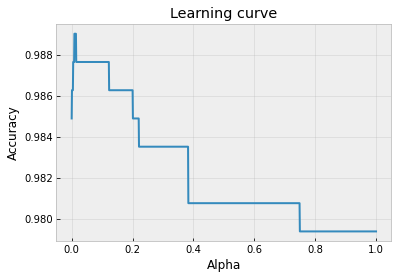

In [85]:
list_alpha = []
list_score = []
highest = 0
high_alpha = 0
for alpha in alphas:
    list_alpha.append(alpha)
    temp = train_and_predict(alpha)
    list_score.append(temp)
    if temp > highest:
        highest = temp
        high_alpha = alpha
  
print("Highest accuracy:",highest,"\nAlpha:",high_alpha)
a_BSpline = make_interp_spline(list_alpha, list_score, k=3)
list_score = a_BSpline(list_alpha)
plt.title('Learning curve')
plt.grid(alpha=.5,linestyle='-')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.plot(list_alpha, list_score)
plt.show()

In [83]:
df = pd.DataFrame()
df['alpha'] = list_alpha
df['score'] = list_score
df.to_csv('alpha_score.csv',index=False)

In [46]:
#initialize training model
nb_classifier = MultinomialNB(alpha = high_alpha)

#train the model
nb_classifier.fit(count_train,y_train)

#predict how well does the model do 
pred = nb_classifier.predict(count_test)

#get accuracy score
metrics.accuracy_score(y_test,pred)

0.989010989010989

In [47]:
#function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


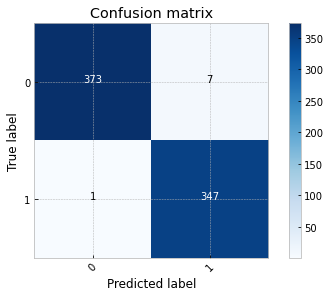

In [48]:
#getting value for confusion matrix
cm = metrics.confusion_matrix(y_test,pred,labels=[0,1])

#plot confusion matrix
plot_confusion_matrix(cm, classes=['0','1'])

In [49]:
print('accuracy %s' % metrics.accuracy_score(pred, y_test),"\n")
print(classification_report(y_test, pred))

accuracy 0.989010989010989 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       380
           1       0.98      1.00      0.99       348

    accuracy                           0.99       728
   macro avg       0.99      0.99      0.99       728
weighted avg       0.99      0.99      0.99       728



In [453]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, y_train)
pred = nb.predict(X_test)
metrics.accuracy_score(pred,y_test)

0.9862637362637363

accuracy 0.9903846153846154
Confusion matrix, without normalization


array([1], dtype=int64)

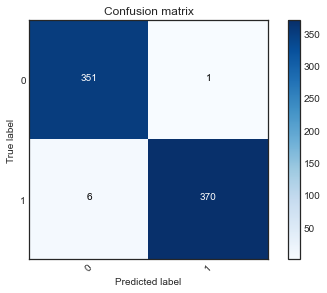

In [455]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

pred = sgd.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(pred, y_test))
cm = metrics.confusion_matrix(y_test,pred,labels=[0,1])

#plot confusion matrix
plot_confusion_matrix(cm, classes=['0','1'])

text = "I do not love you"
clean_text = review_cleaning(text)
text_series = pd.Series(clean_text)
result = sgd.predict(text_series)
result

In [486]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


pred = logreg.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(pred, y_test))

accuracy 0.989010989010989
<class 'sklearn.pipeline.Pipeline'>


In [117]:
btn = widgets.Button(description='Identify now!')
text = widgets.Text(placeholder="Enter your letter",description="Letter:")
display(text)
display(btn)

def predict_letter(text):
    test_series = pd.Series(text)
    ct_test = count_vectorizer.transform(test_series)
    score = nb_classifier.predict(ct_test)
    if score == 1:
        return "love"
    else:
        return "think too much"
    
def btn_eventhandler(obj):
    print(predict_letter(text.value))
    
btn.on_click(btn_eventhandler)


Text(value='', description='Letter:', placeholder='Enter your letter')

Button(description='Identify now!', style=ButtonStyle())

think too much
love


In [115]:
def predict_letter(text):
    test_series = pd.Series(text)
    ct_test = count_vectorizer.transform(test_series)
    score = nb_classifier.predict(ct_test)
    if score == 1:
        return "love"
    else:
        return "think too much"

print(predict_letter("congratulation for your promotion"))

think too much
